In [1]:
# ============================================================
# Functional Autoencoder (nonlinear FAE) + Latent VAR Forecasting
# Australia Fertility Data: train up to 2010, forecast 2011–2015
# ============================================================

import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import math

# -------------------------
# Reproducibility
# -------------------------
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# -------------------------
# Load & preprocess Australia fertility data
# -------------------------
df = pd.read_csv("Australiafertility.csv")

ages = df["age"].to_numpy()          # shape [n_age]
year_cols = [c for c in df.columns if c != "age"]
years = np.array([int(c) for c in year_cols])

# matrix: rows = ages, cols = years
rates = df[year_cols].to_numpy()  

# Smooth each year curve as a function of age
smoothed = np.zeros_like(rates)
for i in range(rates.shape[1]): # Loop over each year
    # Build the spline f_i(x) that minimizes reconstruction error + smoothing penalty (Second derivative):
    spl = UnivariateSpline(ages, rates[:, i], s=50.0)  
    smoothed[:, i] = spl(ages) # Evaluate that function at all ages (y = f_i(x_j)) and store the smooth curve

# For FAE, we want: rows = samples, cols = time points.
# Use smoothed data as the curves
x_raw = smoothed.T.astype(float)      # [n_year, n_age]

# Centralizing the data (mean over ALL years, as in your original code)
x = torch.tensor(x_raw, dtype=torch.float32)
x_mean = torch.mean(x, dim=0)          # [n_age]
x_centered = x - x_mean                # this goes into the FAE

# Time grid: rescale ages to [0,1]
tpts_np = ages.astype(float)
tpts_rescale = (tpts_np - tpts_np.min()) / (tpts_np.max() - tpts_np.min())
tpts = torch.tensor(tpts_rescale, dtype=torch.float32)
n_tpts = len(tpts)

# -------------------------
# Time split: train <= 2010, test = 2011-2015
# -------------------------
train_end_year = 2010
test_years = np.array([2011, 2012, 2013, 2014, 2015])
L = len(test_years)

train_mask = years <= train_end_year
test_mask = np.isin(years, test_years)

train_years = years[train_mask]
test_years_present = years[test_mask]

if len(test_years_present) != L:
    missing = set(test_years.tolist()) - set(test_years_present.tolist())
    raise ValueError(f"Missing test years in CSV: {sorted(list(missing))}")

x_train_all = x_centered[train_mask]   # [T_train, n_age] in year order of CSV cols
x_test_all = x_centered[test_mask]     # [L, n_age] in year order of CSV cols

# Ensure chronological order (important for VAR)
train_order = np.argsort(train_years)
test_order = np.argsort(test_years_present)
train_years = train_years[train_order]
test_years_present = test_years_present[test_order]
x_train_all = x_train_all[train_order]
x_test_all = x_test_all[test_order]

In [2]:
# -------------------------
# Basis construction (Fourier + Bspline)
# -------------------------
class BasisFCBuilder:
    """
    Build basis matrix evaluated on tpts.
    Output shape: [n_time, n_basis]
    """
    def __init__(self, n_basis=20, basis_type="Fourier", custom_basis_fn=None,
                 bspline_degree=3):
        self.n_basis = n_basis
        self.basis_type = basis_type
        self.basis_type_l = basis_type.lower()
        self.custom_basis_fn = custom_basis_fn
        self.bspline_degree = bspline_degree

    def __call__(self, tpts):
        return self.build(tpts)

    def build(self, tpts: torch.Tensor):
        if self.custom_basis_fn is not None:
            B = self.custom_basis_fn(tpts)
            if not torch.is_tensor(B):
                B = torch.tensor(B, dtype=torch.float32)
            return B.float()

        if self.basis_type_l == "fourier":
            return self._build_fourier(tpts)
        elif self.basis_type_l in ("bspline", "b-spline", "b_spline"):
            return self._build_bspline(tpts, degree=self.bspline_degree)
        else:
            raise ValueError("basis_type must be 'Fourier' or 'Bspline'.")

    def _build_fourier(self, tpts: torch.Tensor):
        t = tpts.flatten()
        t_min = t.min()
        t_max = t.max()
        denom = (t_max - t_min).clamp_min(1e-8)
        tau = (t - t_min) / denom  # [0,1]

        n_time = tpts.shape[0]
        n_basis = self.n_basis
        device = t.device

        B = torch.zeros(n_time, n_basis, dtype=torch.float32, device=device)
        if n_basis > 0:
            B[:, 0] = 1.0

        k = 1
        idx = 1
        while idx < n_basis:
            B[:, idx] = torch.sin(2.0 * math.pi * k * tau)
            idx += 1
            if idx < n_basis:
                B[:, idx] = torch.cos(2.0 * math.pi * k * tau)
                idx += 1
            k += 1
        return B

    def _build_bspline(self, tpts: torch.Tensor, degree: int = 3):
        t = tpts.flatten()
        t_min = t.min()
        t_max = t.max()
        denom = (t_max - t_min).clamp_min(1e-8)
        tau = (t - t_min) / denom
        tau_np = tau.detach().cpu().numpy()

        n_time = tau_np.shape[0]
        n_basis = self.n_basis
        p = degree

        if n_basis < p + 1:
            raise ValueError(f"Bspline: n_basis={n_basis} must be at least degree+1={p+1}.")

        n_int = max(n_basis - p - 1, 0)
        if n_int > 0:
            interior = np.linspace(0.0, 1.0, n_int + 2)[1:-1]
            knots = np.concatenate((np.zeros(p + 1), interior, np.ones(p + 1)))
        else:
            knots = np.concatenate((np.zeros(p + 1), np.ones(p + 1)))

        N = np.zeros((n_basis, n_time), dtype=np.float64)

        for i in range(n_basis):
            left = knots[i]
            right = knots[i + 1]
            N[i, :] = np.where((tau_np >= left) & (tau_np < right), 1.0, 0.0)
        N[-1, tau_np == 1.0] = 1.0

        for k in range(1, p + 1):
            N_next = np.zeros_like(N)
            for i in range(n_basis):
                denom_left = knots[i + k] - knots[i]
                if denom_left > 0:
                    coeff_left = (tau_np - knots[i]) / denom_left
                    N_left = coeff_left * N[i, :]
                else:
                    N_left = 0.0

                denom_right = knots[i + k + 1] - knots[i + 1] if (i + 1) < n_basis else 0.0
                if denom_right > 0 and (i + 1) < n_basis:
                    coeff_right = (knots[i + k + 1] - tau_np) / denom_right
                    N_right = coeff_right * N[i + 1, :]
                else:
                    N_right = 0.0

                N_next[i, :] = N_left + N_right
            N = N_next

        B_np = N.T
        B = torch.tensor(B_np, dtype=torch.float32, device=tpts.device)
        return B

In [36]:
# -------------------------
# FAE model (nonlinear)
# -------------------------
class FAEVanilla(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, init_weight_sd=None):
        super().__init__()

        ## Select one of the following options (comment out the other one)

        # --------------------------------------------------
        # Opt 1: Linear FAE with 1 hidden layer
        # --------------------------------------------------
        #self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        #self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        #self.activation = nn.Identity()

        # --------------------------------------------------
        # Opt 2: Nonlinear FAE with 3 hidden layers
        # --------------------------------------------------
        self.fc1 = nn.Linear(n_basis_project, 100, bias=False)
        self.fc2 = nn.Linear(100, n_rep, bias=False)
        self.fc3 = nn.Linear(n_rep, 100, bias=False)
        self.fc4 = nn.Linear(100, n_basis_revert, bias=False)
        self.activation = nn.Sigmoid()

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    def project(self, x, tpts, basis_fc):
        t = tpts.flatten()
        dt = t[1:] - t[:-1]
        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # [n_time]

        n_time = x.shape[1]
        if basis_fc.shape[0] == n_time:
            B = basis_fc
        elif basis_fc.shape[1] == n_time:
            B = basis_fc.T
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_time={n_time}")

        return (x * W) @ B  # [batch, n_basis]

    def revert(self, coef, basis_fc):
        n_basis = coef.shape[1]
        if basis_fc.shape[1] == n_basis:
            return coef @ basis_fc.T
        elif basis_fc.shape[0] == n_basis:
            return coef @ basis_fc
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_basis={n_basis}")

    def decode_from_rep(self, rep, basis_fc_revert):
        """
        rep: [batch, n_rep]
        Returns reconstructed curve in time domain: [batch, n_time]
        """

        ## Opt 1: Linear
        #coef = self.decoder(rep)

        ## Opt 2: Nonlinear
        t2 = self.activation(self.fc3(rep))
        coef = self.fc4(t2)

        x_hat = self.revert(coef, basis_fc_revert)
        return x_hat, coef

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)

        ## Opt 1: Linear
        #rep = self.activation(self.encoder(feature))
        #coef = self.decoder(rep)

        ## Opt 2: Nonlinear
        t1 = self.activation(self.fc1(feature))
        rep = self.fc2(t1)
        t2 = self.activation(self.fc3(rep))
        coef = self.fc4(t2)

        x_hat = self.revert(coef, basis_fc_revert)
        return x_hat, rep, feature, coef

In [37]:
# -------------------------
# Penalty (smoothness) and RMSE
# -------------------------
def diff_penalty(coef):
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))

# RMSE (Relative MSE) - normalized MSE by the variance of the target = MSE/Var(y)
def relative_mse_from_preds(y_hat: torch.Tensor, y_true: torch.Tensor, eps: float = 1e-12) -> float:
    """
    relMSE = MSE / Var(y_true)  ==  1 - R^2
    """
    mse = torch.mean((y_hat - y_true) ** 2)
    var = torch.var(y_true, unbiased=False)  # population variance
    rel_mse = mse / (var.clamp_min(eps))
    return float(rel_mse.detach().cpu())

def relative_rmse_from_preds(y_hat: torch.Tensor, y_true: torch.Tensor, eps: float = 1e-12) -> float:
    return math.sqrt(relative_mse_from_preds(y_hat, y_true, eps=eps))


# -------------------------
# Simple VAR(1) for latent series
# -------------------------
def fit_var1(H: np.ndarray, ridge: float = 1e-5):
    """
    H: shape [T, K] T = number of years, k = latent dimension
    Fits VAR(1): H_t ≈ b + A H_{t-1}
    Returns: b [K] intercept, A [K,K]
    """
    T, K = H.shape
    if T < 2:
        raise ValueError("Need at least 2 time points to fit VAR(1).")
    
    # Build regression data:
    X = H[:-1, :]                     # [1,h_{t-1}]: [T-1, K] -> h_1,...,h_{T-1}
    Y = H[1:, :]                      # h_t: [T-1, K] -> h_2,...,h_T
    X_aug = np.hstack([np.ones((T-1, 1)), X])   # add intercept: [T-1, 1+K]

    # Ridge-regularized least squares: B = (X'X + rI)^(-1) X'Y
    XtX = X_aug.T @ X_aug
    reg = ridge * np.eye(XtX.shape[0])
    B = np.linalg.solve(XtX + reg, X_aug.T @ Y)  # [1+K, K]

    # Extract parameters
    b = B[0, :]                       # [K]
    A = B[1:, :].T                    # [K,K] so that A @ h_{t-1} + b
    return b, A

def forecast_var1(h_last: np.ndarray, b: np.ndarray, A: np.ndarray, steps: int):
    """
    h_last: h_t: [K] last observed latent
    b, A = fitted VAR(1) parameters
    steps = how many years to forecast
    Returns: [steps, K]
    """
    K = h_last.shape[0]
    out = np.zeros((steps, K), dtype=float)
    h = h_last.copy()
    for i in range(steps):
        h = b + (A @ h) # h_t = b + A h_{t-1}
        out[i, :] = h
    return out

In [38]:
# -------------------------
# Train / evaluate
# -------------------------
def train_one_epoch(model, loader, optimizer, loss_fn, device,
                    tpts, basis_fc_project, basis_fc_revert,
                    pen=None, lamb=0.0):

    model.train()
    total_loss = 0.0
    total_score_loss = 0.0
    n_batches = 0

    for x_batch in loader:
        x_batch = x_batch.to(device).float()
        optimizer.zero_grad()

        x_hat, rep, feature, coef = model(x_batch, tpts, basis_fc_project, basis_fc_revert)
        loss = loss_fn(x_hat, x_batch)

        score_loss = 0.0
        if feature.shape == coef.shape:
            score_loss = loss_fn(feature, coef)
            total_score_loss += float(score_loss.detach().cpu())

        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
        n_batches += 1

    return total_loss / max(n_batches, 1), total_score_loss / max(n_batches, 1)

@torch.no_grad()
def evaluate(model, x_data, loss_fn, device, tpts, basis_fc_project, basis_fc_revert):
    model.eval()
    x_data = x_data.to(device).float()
    x_hat, rep, feature, coef = model(x_data, tpts, basis_fc_project, basis_fc_revert)
    loss = loss_fn(x_hat, x_data)
    return x_hat, rep, float(loss.detach().cpu()), coef

@torch.no_grad()
def latent_forecast_and_decode(model, H_train, steps, device, basis_fc_revert):
    """
    H_train: torch.Tensor [T_train, K] in chronological order
    Fit VAR(1) on H_train, forecast steps ahead, decode to curves.
    Returns:
      H_fore: h hats: forecasted latent vectors, shape [steps, K]
      X_fore: X hats: forecasted curves on the grid, shape [steps, n_time]
    """
    H_np = H_train.detach().cpu().numpy()
    b, A = fit_var1(H_np, ridge=1e-8) # Fit VAR(1) on the latent series
    h_last = H_np[-1, :] # Grab the last latent vector h_T
    Hf_np = forecast_var1(h_last, b, A, steps=steps) # Forecast future latents

    H_fore = torch.tensor(Hf_np, dtype=torch.float32, device=device)
    X_fore, _ = model.decode_from_rep(H_fore, basis_fc_revert) # Decode h hat into forecasted curves
    return H_fore, X_fore

# -------------------------
# Main experiment (FAE training + latent forecasting)
# -------------------------
def run_fae_experiment(
    x_train_all,
    x_test_all,
    train_years,
    test_years,
    tpts,
    n_iter=1,
    split_rate=0.85, # split within train years only
    epochs=2000,
    batch_size=16,
    n_rep=5,
    n_basis_project=20,
    n_basis_revert=20,
    basis_type_project="Fourier",
    basis_type_revert="Fourier",
    custom_basis_project_fn=None,
    custom_basis_revert_fn=None,
    pen="diff",
    lamb=0.001,
    lr=1e-3,
    weight_decay=1e-6,
    init_weight_sd=0.5,
    log_every=100,
    device="cpu",
    seed=743,
    save_extras=True,
    forecast_every=200, # do latent VAR forecast evaluation every N epochs (set None to disable)
):
    set_seed(seed)
    device = torch.device(device)

    basis_project_builder = BasisFCBuilder(
        n_basis=n_basis_project,
        basis_type=basis_type_project,
        custom_basis_fn=custom_basis_project_fn
    )
    basis_revert_builder = BasisFCBuilder(
        n_basis=n_basis_revert,
        basis_type=basis_type_revert,
        custom_basis_fn=custom_basis_revert_fn
    )

    basis_fc_project = basis_project_builder.build(tpts.to(device)).to(device)
    basis_fc_revert = basis_revert_builder.build(tpts.to(device)).to(device)

    tpts = tpts.to(device).float()
    loss_fn = nn.MSELoss()

    n_log_points = epochs // log_every

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "per_epoch_train_recon_loss": [[] for _ in range(n_log_points)],
        "per_epoch_test_recon_loss": [[] for _ in range(n_log_points)],

        # RMSE
        "per_epoch_forecast_rmse": [],
        "final_forecast_rmse": None,

        # forecasting metrics (2011-2015)
        "per_epoch_forecast_mse": [],
        "final_forecast_mse": None,
    }

    # ensure tensors
    if not torch.is_tensor(x_train_all):
        x_train_all = torch.tensor(x_train_all, dtype=torch.float32)
    else:
        x_train_all = x_train_all.float()

    if not torch.is_tensor(x_test_all):
        x_test_all = torch.tensor(x_test_all, dtype=torch.float32)
    else:
        x_test_all = x_test_all.float()

    idx_all = np.arange(x_train_all.shape[0])

    for r in range(n_iter):
        # reconstruction validation split only within TRAIN PERIOD
        idx_train, idx_val = train_test_split(
            idx_all,
            train_size=split_rate,
            random_state=seed + r,
            shuffle=True
        )

        TrainData = x_train_all[idx_train]
        ValData = x_train_all[idx_val]
        TestData = x_test_all  # 2011-2015 (true held-out future years)

        train_loader = DataLoader(TrainData, batch_size=batch_size, shuffle=True)

        model = FAEVanilla(
            n_basis_project, n_rep, n_basis_revert, init_weight_sd=init_weight_sd
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(1, epochs + 1):
            train_loss, score_loss = train_one_epoch(
                model, train_loader, optimizer, loss_fn, device,
                tpts, basis_fc_project, basis_fc_revert,
                pen=pen, lamb=lamb
            )

            if epoch % log_every == 0:
                _, _, train_loss_eval, _ = evaluate(
                    model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
                )
                _, _, val_loss, _ = evaluate(
                    model, ValData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
                )

                k = (epoch // log_every) - 1
                history["per_epoch_train_recon_loss"][k].append(train_loss_eval)
                history["per_epoch_test_recon_loss"][k].append(val_loss)

                # need predictions to compute variance-normalized error
                Xhat_train, _, _, _ = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
                Xhat_val,   _, _, _ = evaluate(model, ValData,   loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

                train_relrmse = relative_rmse_from_preds(Xhat_train, TrainData.to(device))
                val_relrmse   = relative_rmse_from_preds(Xhat_val,   ValData.to(device))


                print(
                    f"[rep {r+1}/{n_iter}] epoch {epoch:4d} | "
                    f"train_recon_relRMSE={train_relrmse:.6f} | val_recon_relRMSE={val_relrmse:.6f}"
                )

            # ---- forecast evaluation while training ---- 
            # It does not change FAE weights! 
            if forecast_every is not None and (epoch % forecast_every == 0):
                # get latent reps for ALL training years in chronological order 
                _, H_train, _, _ = evaluate(
                    model, x_train_all, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
                )
                # H_train is in the order of x_train_all, which we ensured is chronological
                _, X_fore = latent_forecast_and_decode(
                    model, H_train, steps=len(test_years), device=device, basis_fc_revert=basis_fc_revert
                )
                # compare forecasted curves to actual future curves (centered)
                mse_fore = float(loss_fn(X_fore, TestData.to(device)).detach().cpu())
                relmse_fore = relative_mse_from_preds(X_fore, TestData.to(device))
                relrmse_fore = math.sqrt(relmse_fore)
                history["per_epoch_forecast_mse"].append((epoch, mse_fore))          # keep raw if you want
                history["per_epoch_forecast_rmse"].append((epoch, relrmse_fore))     # now stores relRMSE

                print(f"           forecast_relRMSE({test_years[0]}-{test_years[-1]})={relrmse_fore:.6f}")

        # final recon eval
        _, _, train_loss, _ = evaluate(
            model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
        )
        _, _, val_loss, _ = evaluate(
            model, ValData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
        )
        history["train_recon_loss"].append(train_loss)
        history["test_recon_loss"].append(val_loss)

        # final latent forecast + decode
        _, H_train, _, _ = evaluate(
            model, x_train_all, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
        )
        H_fore, X_fore = latent_forecast_and_decode(
            model, H_train, steps=len(test_years), device=device, basis_fc_revert=basis_fc_revert
        )

        final_fore_mse = float(loss_fn(X_fore, x_test_all.to(device)).detach().cpu())
        final_fore_relmse = relative_mse_from_preds(X_fore, x_test_all.to(device))
        final_fore_relrmse = math.sqrt(final_fore_relmse)

        history["final_forecast_mse"] = final_fore_mse          # raw
        history["final_forecast_rmse"] = final_fore_relrmse     # now relative

        print(f"\nFINAL forecast relRMSE on {test_years[0]}-{test_years[-1]}: {final_fore_relrmse:.6f}\n")



        if save_extras and (r == n_iter - 1):
            # also compute reconstructions for plotting
            Xhat_train, _, _, _ = evaluate(
                model, x_train_all, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
            )
            Xhat_test, _, _, _ = evaluate(
                model, x_test_all, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
            )
            history["extras"] = {
                "model": model,
                "tpts": tpts,
                "basis_fc_project": basis_fc_project,
                "basis_fc_revert": basis_fc_revert,
                "device": device,
                "loss_fn": loss_fn,

                "train_years": train_years,
                "test_years": test_years,
                "ages": ages,
                "x_mean": x_mean,

                "x_train_all": x_train_all,
                "x_test_all": x_test_all,
                "Xhat_train": Xhat_train.detach().cpu(),
                "Xhat_test": Xhat_test.detach().cpu(),

                "H_train": H_train.detach().cpu(),
                "H_fore": H_fore.detach().cpu(),
                "X_fore": X_fore.detach().cpu(),
            }

    return history

# -------------------------
# Plotting helpers
# -------------------------
def plot_history(history, log_every=100):
    train_mse_mean = [np.mean(v) for v in history["per_epoch_train_recon_loss"]]
    train_mse_sd   = [np.std(v)  for v in history["per_epoch_train_recon_loss"]]
    val_mse_mean   = [np.mean(v) for v in history["per_epoch_test_recon_loss"]]
    val_mse_sd     = [np.std(v)  for v in history["per_epoch_test_recon_loss"]]

    epochs_grid = np.arange(log_every, len(train_mse_mean) * log_every + 1, log_every)

    plt.figure()
    plt.plot(epochs_grid, train_mse_mean, '-o', label='Train recon MSE')
    plt.fill_between(
        epochs_grid,
        np.array(train_mse_mean) - np.array(train_mse_sd),
        np.array(train_mse_mean) + np.array(train_mse_sd),
        alpha=0.2
    )
    plt.plot(epochs_grid, val_mse_mean, '-o', label='Val recon MSE (within train period)')
    plt.fill_between(
        epochs_grid,
        np.array(val_mse_mean) - np.array(val_mse_sd),
        np.array(val_mse_mean) + np.array(val_mse_sd),
        alpha=0.2
    )
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('FAE Reconstruction Error over Training')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_forecast_mse(history):
    if len(history.get("per_epoch_forecast_mse", [])) == 0:
        print("No forecast MSE logged (set forecast_every to an integer).")
        return
    ep = [e for e, m in history["per_epoch_forecast_mse"]]
    ms = [m for e, m in history["per_epoch_forecast_mse"]]
    plt.figure()
    plt.plot(ep, ms, '-o')
    plt.xlabel("Epoch")
    plt.ylabel("Forecast MSE (2011–2015)")
    plt.title("Latent VAR(1) forecast error during FAE training")
    plt.tight_layout()
    plt.show()


def plot_forecast_rmse(history):
    if len(history.get("per_epoch_forecast_rmse", [])) == 0:
        print("No forecast RMSE logged (set forecast_every to an integer).")
        return
    ep = [e for e, r in history["per_epoch_forecast_rmse"]]
    rs = [r for e, r in history["per_epoch_forecast_rmse"]]
    plt.figure()
    plt.plot(ep, rs, '-o')
    plt.xlabel("Epoch")
    plt.ylabel("Forecast RMSE (2011–2015)")
    plt.title("Latent VAR(1) forecast error during FAE training")
    plt.tight_layout()
    plt.show()



def plot_forecast_curves(history, which_age_grid=True, add_mean_back=False):
    """
    Plots actual vs predicted curves for 2011–2015 (centered by default).
    If add_mean_back=True, it adds x_mean back for original scale.
    """
    ex = history.get("extras", None)
    if ex is None:
        print("No extras saved. Run with save_extras=True.")
        return

    ages_local = ex["ages"]
    test_years_local = ex["test_years"]

    X_true = ex["x_test_all"].cpu().numpy()
    X_pred = ex["X_fore"].cpu().numpy()

    if add_mean_back:
        mu = ex["x_mean"].cpu().numpy()
        X_true = X_true + mu[None, :]
        X_pred = X_pred + mu[None, :]

    for i, yr in enumerate(test_years_local):
        plt.figure()
        plt.plot(ages_local, X_true[i], label=f"Actual {yr}")
        plt.plot(ages_local, X_pred[i], label=f"Forecast {yr}")
        plt.xlabel("Age")
        plt.ylabel("Fertility rate" + (" (original scale)" if add_mean_back else " (centered)"))
        plt.title(f"Forecasted curve vs actual: {yr}")
        plt.legend()
        plt.tight_layout()
        plt.show()


def plot_forecast_curves_side_by_side(history):
    ex = history.get("extras", None)
    if ex is None:
        print("No extras saved. Run with save_extras=True.")
        return

    ages_local = ex["ages"]
    test_years_local = ex["test_years"]

    X_true_c = ex["x_test_all"].cpu().numpy()
    X_pred_c = ex["X_fore"].cpu().numpy()

    mu = ex["x_mean"].cpu().numpy()

    # original scale
    X_true_o = X_true_c + mu[None, :]
    X_pred_o = X_pred_c + mu[None, :]

    for i, yr in enumerate(test_years_local):

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

        # ---- centered ----
        axes[0].plot(ages_local, X_true_c[i], label=f"Actual {yr}")
        axes[0].plot(ages_local, X_pred_c[i], label=f"Forecast {yr}")
        axes[0].set_title(f"{yr} (centered)")
        axes[0].set_xlabel("Age")
        axes[0].set_ylabel("Fertility rate (centered)")
        axes[0].legend()

        # ---- original scale ----
        axes[1].plot(ages_local, X_true_o[i], label=f"Actual {yr}")
        axes[1].plot(ages_local, X_pred_o[i], label=f"Forecast {yr}")
        axes[1].set_title(f"{yr} (original scale)")
        axes[1].set_xlabel("Age")
        axes[1].set_ylabel("Fertility rate")
        axes[1].legend()

        plt.suptitle(f"Forecast vs Actual — {yr}", fontsize=14)
        plt.tight_layout()
        plt.show()

[rep 1/1] epoch  100 | train_recon_relRMSE=0.820818 | val_recon_relRMSE=0.800523
[rep 1/1] epoch  200 | train_recon_relRMSE=0.713717 | val_recon_relRMSE=0.687123
           forecast_relRMSE(2011-2015)=0.845921
[rep 1/1] epoch  300 | train_recon_relRMSE=0.630867 | val_recon_relRMSE=0.600494
[rep 1/1] epoch  400 | train_recon_relRMSE=0.560003 | val_recon_relRMSE=0.526069
           forecast_relRMSE(2011-2015)=0.719904
[rep 1/1] epoch  500 | train_recon_relRMSE=0.497594 | val_recon_relRMSE=0.460014
[rep 1/1] epoch  600 | train_recon_relRMSE=0.441776 | val_recon_relRMSE=0.400392
           forecast_relRMSE(2011-2015)=0.627667
[rep 1/1] epoch  700 | train_recon_relRMSE=0.391564 | val_recon_relRMSE=0.346281
[rep 1/1] epoch  800 | train_recon_relRMSE=0.346446 | val_recon_relRMSE=0.297817
           forecast_relRMSE(2011-2015)=0.531342
[rep 1/1] epoch  900 | train_recon_relRMSE=0.306124 | val_recon_relRMSE=0.254599
[rep 1/1] epoch 1000 | train_recon_relRMSE=0.269793 | val_recon_relRMSE=0.21639

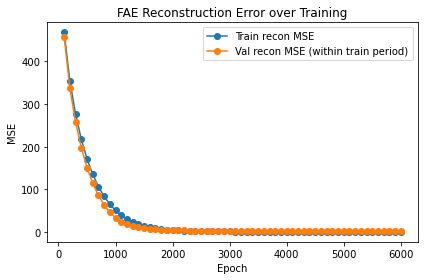

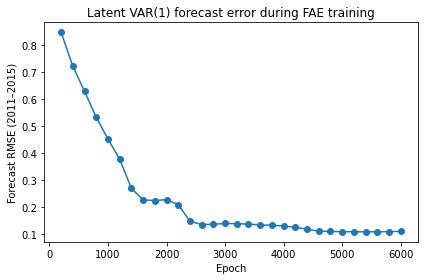

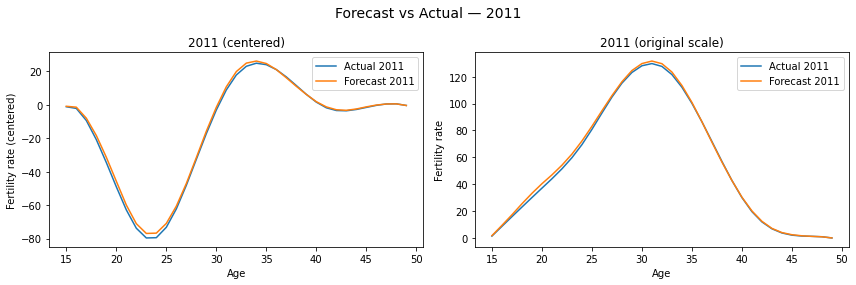

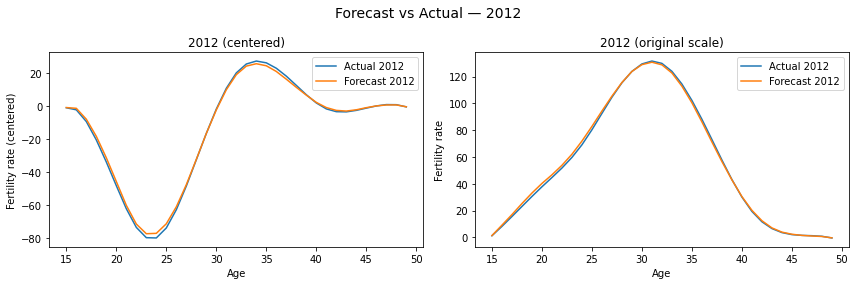

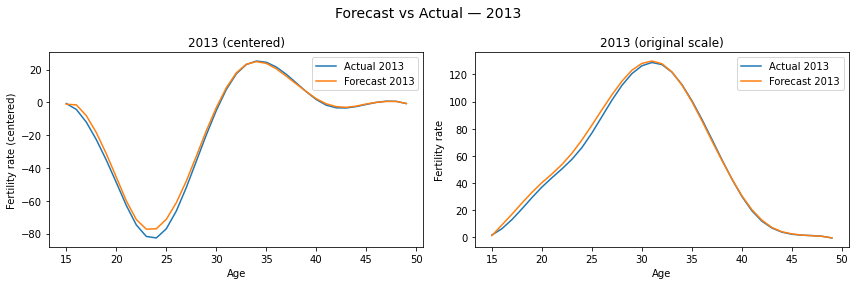

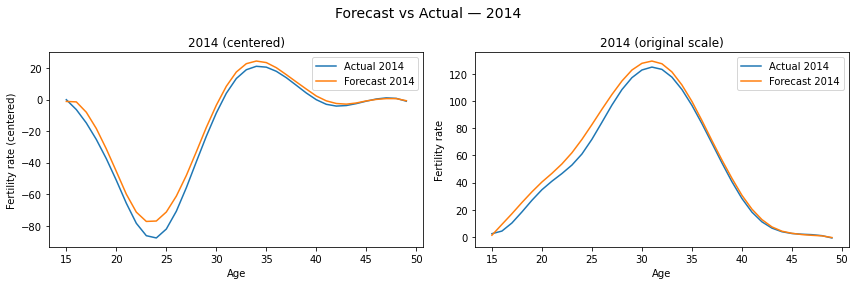

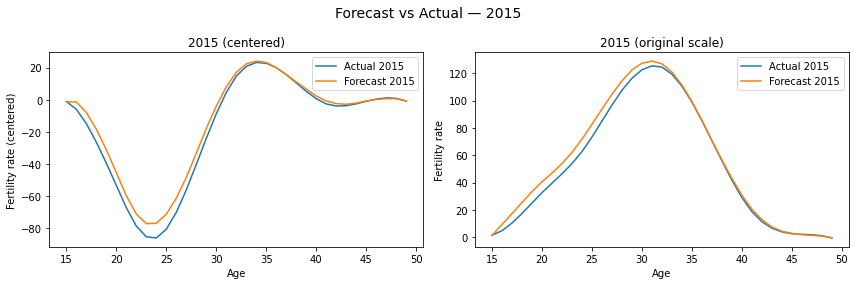

In [39]:
# -------------------------
# Run the experiment
# -------------------------
if __name__ == "__main__":
    history = run_fae_experiment(
        x_train_all=x_train_all,       # <= 2010
        x_test_all=x_test_all,         # 2011-2015
        train_years=train_years,
        test_years=test_years,
        tpts=tpts,
        n_iter=1,
        epochs=6000,
        log_every=100,
        lr=3e-4,  
        weight_decay=1e-4,
        batch_size=16,
        lamb=0.001, # Smoothing parameter

        basis_type_project="Bspline",
        basis_type_revert="Bspline",
        n_rep=5,
        n_basis_project=30,
        n_basis_revert=30,

        device="cpu",
        forecast_every=200,   # set to None to disable
    )

    # Reconstruction plot (within train period split)
    plot_history(history, log_every=100)

    # Forecast MSE during training
    plot_forecast_rmse(history)

    # Forecasted curves vs actual for 2011–2015
    plot_forecast_curves_side_by_side(history)
    #plot_forecast_curves(history, add_mean_back=False)
    #plot_forecast_curves(history, add_mean_back=True) # original scale

# FPCA Comparison 

In [40]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

# Helper for calculating integral of f(x)dx 
def trapezoid_weights(x: np.ndarray) -> torch.Tensor:
    """
    Trapezoid quadrature weights for grid x (increasing).
    Returns torch tensor of shape [P].
    """
    x = np.asarray(x, dtype=float)
    dx = np.diff(x)
    w = np.zeros_like(x)
    w[0] = dx[0] / 2.0
    w[-1] = dx[-1] / 2.0
    if len(x) > 2:
        w[1:-1] = (x[2:] - x[:-2]) / 2.0
    return torch.tensor(w, dtype=torch.float32)

# FPCA 
def weighted_fpca_fit(X_train: torch.Tensor, w_age: torch.Tensor, K: int):
    """
    Classical weighted FPCA on discretized functions.
    Inner product: <f,g> = sum_j f_j g_j w_age_j

    X_train: [T, P] (curves in age grid)
    w_age:   [P] trapezoid weights over age grid
    K: number of components

    Returns:
      mu: [P]
      phi: [K, P] eigenfunctions (orthonormal under w_age)
      scores: [T, K]
      eigvals: [K]
    """
    # De-mean the data f = X - mu
    T, P = X_train.shape
    mu = X_train.mean(dim=0, keepdim=True)      # [1,P]
    Xc = X_train - mu                            # [T,P]

    # weighted inner product
    sw = torch.sqrt(w_age).view(1, -1)          # [1,P]
    Xw = Xc * sw                                 # [T,P]

    # SVD of weighted data
    U, S, Vh = torch.linalg.svd(Xw, full_matrices=False)  # Vh: [P,P] or [r,P]
    V = Vh.transpose(0, 1)                       # [P,r]

    # Convert back to eigenfunctions in original space:
    phi = (V[:, :K] / sw.flatten()[:, None]).T   # [K,P]

    # Normalize phi to ensure orthonormality under w_age
    for k in range(K):
        norm = torch.sqrt(torch.sum(phi[k] * phi[k] * w_age))
        phi[k] = phi[k] / norm.clamp_min(1e-12)

    # Scores: beta_{t,k} = <f_t - mu, phi_k> = ∫ (f_t - mu) phi_k ≈ sum_j (Xc_tj * phi_kj * w_j)
    scores = (Xc * w_age) @ phi.T               # [T,K]
    
    # Eigenvalues
    eigvals = (S[:K] ** 2) / max(T - 1, 1)
    return mu.squeeze(0), phi, scores, eigvals


# “Robust-ish” Hyndman–Ullah two-step weighting
def robust_fpca_two_step(X_train: torch.Tensor, w_age: torch.Tensor, K: int, zeta: float = 3.0):
    """
    Two-step robust FPCA inspired by Hyndman & Ullah (2007) Section 3.3.
    Step 1: fit (non-robust) FPCA
    Step 2: compute per-year integrated squared error v_t, create binary weights, refit using weighted SVD.

    Returns mu, phi, scores, eigvals, year_weights
    """
    mu1, phi1, scores1, eigvals1 = weighted_fpca_fit(X_train, w_age, K)

    # reconstruction and integrated squared error v_t
    Xhat1 = mu1.view(1, -1) + scores1 @ phi1
    resid = X_train - Xhat1
    v = torch.sum((resid * resid) * w_age.view(1, -1), dim=1)  # [T]

    # Robust threshold
    s = torch.median(v)
    thresh = s + zeta * torch.sqrt(s.clamp_min(1e-12))
    year_w = (v < thresh).float()  # binary weights, as in paper

    # Downweight entire curves
    sw_t = torch.sqrt(year_w).view(-1, 1)       # [T,1]
    Xw = X_train * sw_t

    # Refit FPCA on weighted curves (still using age weights inside)
    mu2, phi2, scores2, eigvals2 = weighted_fpca_fit(Xw, w_age, K)

    # Scores computed on the ORIGINAL X_train centered by mu2 (not on Xw!), so the time series uses actual values.
    Xc2 = X_train - mu2.view(1, -1)
    scores2 = (Xc2 * w_age) @ phi2.T

    return mu2, phi2, scores2, eigvals2, year_w


# VAR(1) on the scores
def fit_var1(H: np.ndarray, ridge: float = 1e-8):
    """
    Fits VAR(1): H_t ≈ b + A H_{t-1}
    H: [T, K]
    Returns b [K], A [K,K]
    """
    T, K = H.shape
    X = H[:-1, :]
    Y = H[1:, :]
    X_aug = np.hstack([np.ones((T-1, 1)), X])   # [T-1, 1+K]
    XtX = X_aug.T @ X_aug
    B = np.linalg.solve(XtX + ridge * np.eye(XtX.shape[0]), X_aug.T @ Y)
    b = B[0, :]
    A = B[1:, :].T
    return b, A

def forecast_var1(h_last: np.ndarray, b: np.ndarray, A: np.ndarray, steps: int):
    K = h_last.shape[0]
    out = np.zeros((steps, K), dtype=float)
    h = h_last.copy()
    for i in range(steps):
        h = b + (A @ h)
        out[i, :] = h
    return out


# Relative MSE
def rel_rmse(y_hat: torch.Tensor, y_true: torch.Tensor, eps: float = 1e-12) -> float:
    """
    relRMSE = sqrt( MSE / Var(y_true) )  = sqrt(1 - R^2)
    """
    mse = torch.mean((y_hat - y_true) ** 2)
    var = torch.var(y_true, unbiased=False)
    return torch.sqrt(mse / var.clamp_min(eps)).item()


# FPCA function 
def fpca_var_forecast(
    X_train_all: torch.Tensor,   # [T_train, P] (your x_train_all)
    X_test_all: torch.Tensor,    # [L, P] (your x_test_all)
    ages: np.ndarray,
    test_years: np.ndarray,
    K: int = 5,
    robust: bool = False,
    zeta: float = 3.0,
):
    w_age = trapezoid_weights(ages)  # [P]

    if robust:
        mu, phi, scores, eigvals, year_w = robust_fpca_two_step(X_train_all, w_age, K, zeta=zeta)
    else:
        mu, phi, scores, eigvals = weighted_fpca_fit(X_train_all, w_age, K)
        year_w = None

    # VAR(1) on scores
    H = scores.detach().cpu().numpy()          # [T_train, K]
    b, A = fit_var1(H, ridge=1e-8)
    # forecast Hf using VAR(1)
    Hf = forecast_var1(H[-1], b, A, steps=len(test_years)) 
    Hf_t = torch.tensor(Hf, dtype=torch.float32)

    # Reconstruct forecast curves with new betas
    X_fore = mu.view(1, -1) + Hf_t @ phi       # [L, P]

    # RMSE on centered scale (matches your evaluation)
    forecast_rmse = rel_rmse(X_fore, X_test_all)

    # Year-by-year plots
    X_true = X_test_all.detach().cpu().numpy()
    X_pred = X_fore.detach().cpu().numpy()

    for i, yr in enumerate(test_years):
        plt.figure()
        plt.plot(ages, X_true[i], label=f"Actual {yr}")
        plt.plot(ages, X_pred[i], label=f"FPCA+VAR(1) forecast {yr}")
        plt.xlabel("Age")
        plt.ylabel("Fertility rate (centered)")
        plt.title(f"FPCA forecast vs actual: {yr}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "X_fore": X_fore,
        "rmse": forecast_rmse,
        "mu": mu, "phi": phi, "scores": scores, "eigvals": eigvals,
        "year_weights": year_w
    }

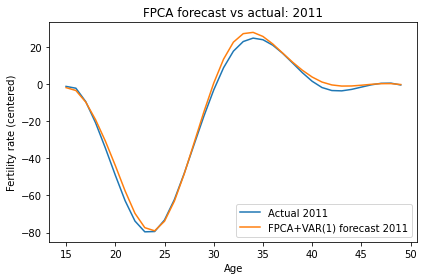

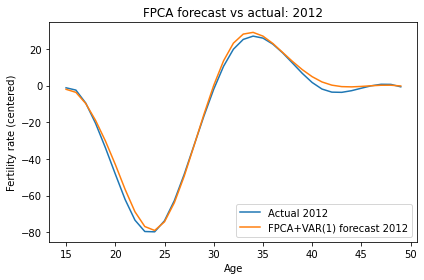

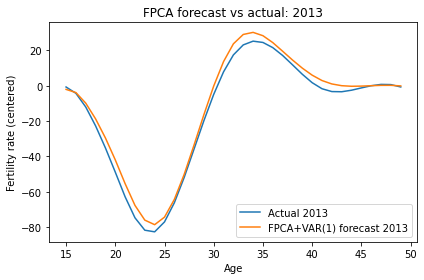

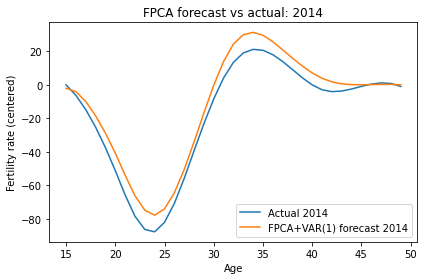

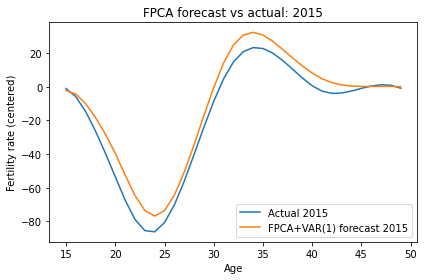

FPCA+VAR(1) forecast relRMSE: 0.16495108604431152
FAE+VAR(1) forecast relRMSE: 0.10970095545053482


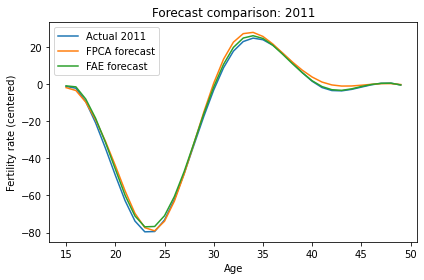

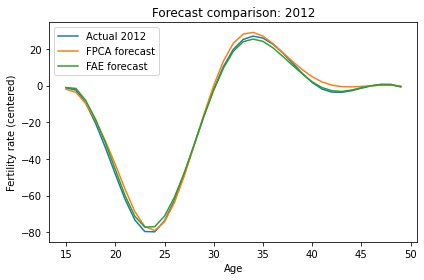

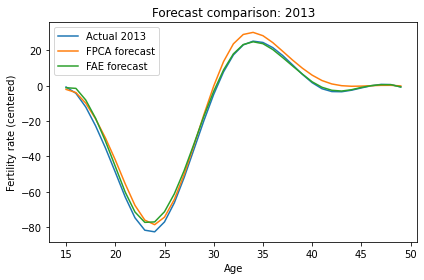

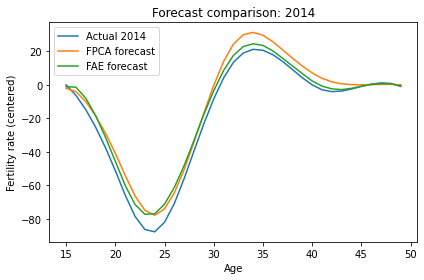

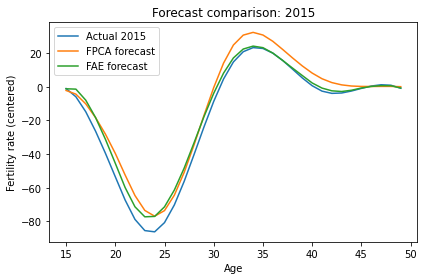

In [41]:
# --- FPCA forecasts ---
fpca_out = fpca_var_forecast(
    X_train_all=x_train_all,
    X_test_all=x_test_all,
    ages=ages,
    test_years=test_years,
    K=5,
    robust=False,
)

print("FPCA+VAR(1) forecast relRMSE:", fpca_out["rmse"])

# --- FAE forecast RMSE ---
fae_X_fore = history["extras"]["X_fore"]          # [L, P]
fae_rmse = rel_rmse(fae_X_fore.cpu(), x_test_all.cpu())
print("FAE+VAR(1) forecast relRMSE:", fae_rmse)

# --- Side-by-side year-by-year plots ---
X_true = x_test_all.cpu().numpy()
X_fpca = fpca_out["X_fore"].cpu().numpy()
X_fae  = fae_X_fore.cpu().numpy()

for i, yr in enumerate(test_years):
    plt.figure()
    plt.plot(ages, X_true[i], label=f"Actual {yr}")
    plt.plot(ages, X_fpca[i], label="FPCA forecast")
    plt.plot(ages, X_fae[i],  label="FAE forecast")
    plt.xlabel("Age")
    plt.ylabel("Fertility rate (centered)")
    plt.title(f"Forecast comparison: {yr}")
    plt.legend()
    plt.tight_layout()
    plt.show()